In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
import random
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [2]:
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_burlington')

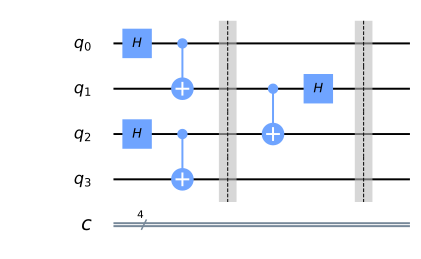

In [3]:
n=4
qc1 = QuantumCircuit(n,n)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qc1.barrier()
qc1.draw(output='mpl')

In [4]:
qc2 = QuantumCircuit(n,n)
qc3 = QuantumCircuit(n,n)
qc4 = QuantumCircuit(n,n)
qcs = [qc1, qc2, qc3, qc4]
for qc in range(3):
    q2 = QuantumCircuit(n,n)
    if qc == 0 or qc == 2:
        q2.z(3)
    if qc == 1 or qc == 2:
        q2.x(3)
    q2.barrier()
    qcs[qc+1]= qcs[0] +q2

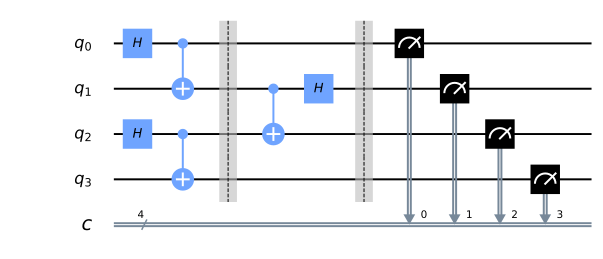

In [5]:
for i in range(4):
    qcs[i].measure([0,1,2,3],[0,1,2,3])
qcs[0].draw(output='mpl')

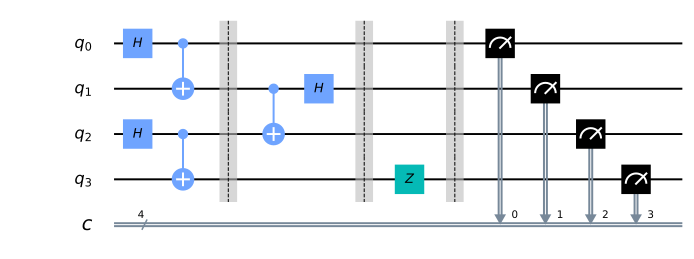

In [6]:
qcs[1].draw(output='mpl')

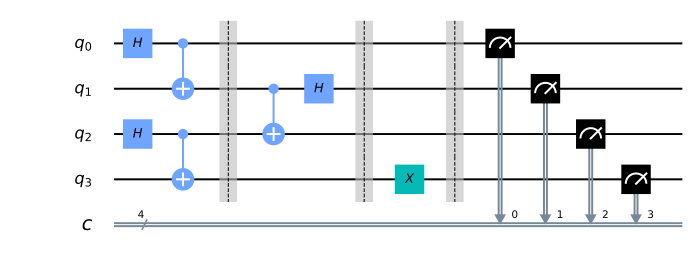

In [7]:
qcs[2].draw(output='mpl')

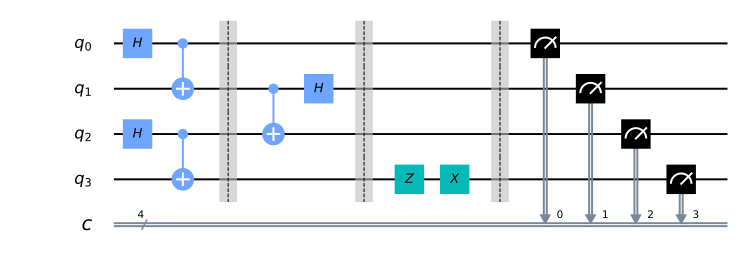

In [8]:
qcs[3].draw(output='mpl')

In [9]:
backends = [simulator,device]
counts =[0,0,0,0,0,0,0,0]
for be in backends:
    for qc in qcs:
        job = execute(qc, backend = be, shots=2500)
        if be == device:
            job_monitor(job)
        bits = [ '1000', '0000', '1110', '1010', '0110', '0010', '1100', '0100','1001', '0001', '1111', '1011', '0111', '0011', '1101', '0101']
        for x in range(4):
            if be == simulator:
                b=0
            else:
                b=4
            if qc == qcs[x]:
                counts[x+b] = job.result().get_counts()
                for bit in bits:
                    if bit not in counts[x+b]:
                        counts[x+b][bit] = 0
                print(counts[b+x])
        print('Done')
        ibmq_sim_results = job.result()
        ibmq_sim_counts = job.result().get_counts()

{'1001': 289, '0000': 324, '0010': 309, '0101': 324, '1110': 298, '1100': 316, '1011': 326, '0111': 314, '1000': 0, '1010': 0, '0110': 0, '0100': 0, '0001': 0, '1111': 0, '0011': 0, '1101': 0}
Done
{'1001': 319, '0000': 332, '0010': 308, '0101': 313, '1110': 329, '1100': 293, '1011': 313, '0111': 293, '1000': 0, '1010': 0, '0110': 0, '0100': 0, '0001': 0, '1111': 0, '0011': 0, '1101': 0}
Done
{'0011': 310, '0110': 330, '1010': 306, '1111': 301, '0001': 324, '0100': 309, '1101': 304, '1000': 316, '0000': 0, '1110': 0, '0010': 0, '1100': 0, '1001': 0, '1011': 0, '0111': 0, '0101': 0}
Done
{'0011': 322, '0110': 323, '1010': 309, '1111': 334, '0001': 303, '0100': 304, '1101': 309, '1000': 296, '0000': 0, '1110': 0, '0010': 0, '1100': 0, '1001': 0, '1011': 0, '0111': 0, '0101': 0}
Done
Job Status: job has successfully run
{'1001': 153, '0110': 137, '0000': 351, '0010': 217, '0100': 131, '1110': 135, '1100': 192, '1011': 176, '1101': 71, '1000': 65, '0011': 127, '1010': 54, '1111': 52, '0101

In [14]:
countssim = {'00': counts[0]["0000"]+counts[1]["0010"]+counts[2]["0100"]+counts[3]["0110"],'10': counts[0]["1000"]+counts[1]["1010"]+counts[2]["1100"]+counts[3]["1110"],'01': counts[0]["0001"]+counts[1]["0011"]+counts[2]["0101"]+counts[3]["0111"],'11': counts[0]["1001"]+counts[1]["1011"]+counts[2]["1101"]+counts[3]["1111"]}
countsdev = {'00': counts[4]["0000"]+counts[5]["0010"]+counts[6]["0100"]+counts[7]["0110"],'10': counts[4]["1000"]+counts[5]["1010"]+counts[6]["1100"]+counts[7]["1110"],'01': counts[4]["0001"]+counts[5]["0011"]+counts[6]["0101"]+counts[7]["0111"],'11': counts[4]["1001"]+counts[5]["1011"]+counts[6]["1101"]+counts[7]["1111"]}

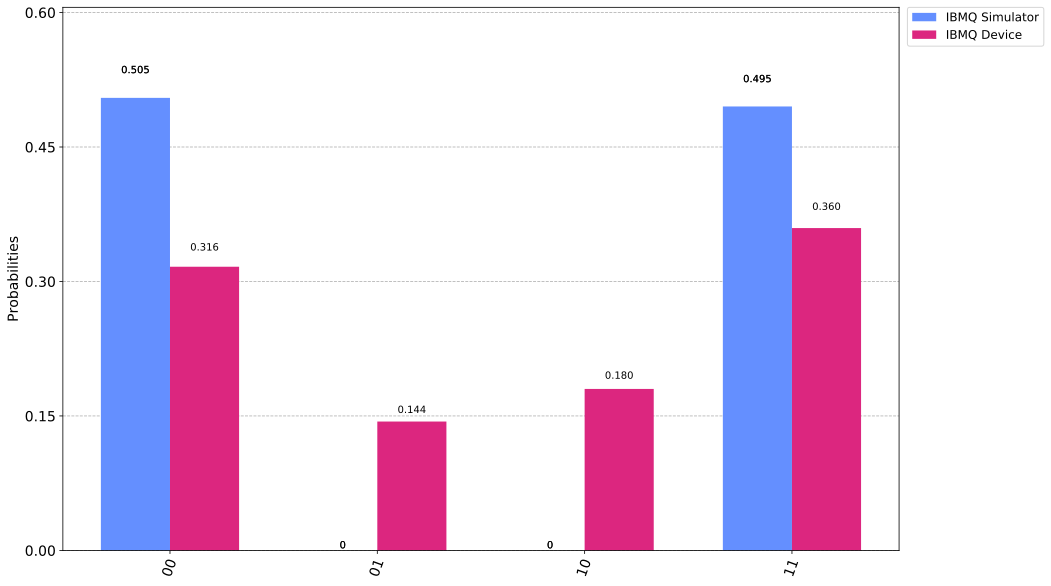

In [15]:
# plotting the results together
plot_histogram([countssim, countsdev],
               legend = ['IBMQ Simulator', 'IBMQ Device'],
               figsize = (15,10))